<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/LSTM_AE/LSTM_AE_Treasury10y.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 147 (delta 71), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (147/147), 120.19 KiB | 4.29 MiB/s, done.
Resolving deltas: 100% (71/71), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Thu Jul 15 15:00:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'Treasury10y'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'LSTM_AE'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8MB 9.7MB/s 
     |████████████████████████████████| 143kB 61.2MB/s 
     |████████████████████████████████| 174kB 57.8MB/s 
     |████████████████████████████████| 102kB 13.4MB/s 
     |████████████████████████████████| 71kB 8.8MB/s 


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'dropout': {
            'values': [0.1, 0.2, 0.3]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop']
        },
        'activation': {
            'values': ['tanh', 'relu']
        }
    }
}

In [13]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'dropout': 0.2,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

    # layer 1
    model.add(LSTM(units=128, return_sequences=True, input_shape=(window_len, 1), activation=config.activation))
    model.add(Dropout(config.dropout))
    # layer 2
    model.add(LSTM(units=64, return_sequences=False, activation=config.activation))
    model.add(Dropout(config.dropout))
    # layer 3
    model.add(RepeatVector(window_len))
    # layer 4
    model.add(LSTM(units=64, return_sequences=True, activation=config.activation))
    model.add(Dropout(config.dropout))
    # layer 5
    model.add(LSTM(units=128, return_sequences=False, activation=config.activation))
    model.add(Dropout(0.1))
    # layer 6
    model.add((Dense(1)))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: ntv7uqhc
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_LSTM_AE/sweeps/ntv7uqhc


In [15]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: jo9l1zlf with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/200
16/16 [==============================] - 31s 336ms/step - loss: 0.1302 - mean_squared_error: 0.1302 - mean_absolute_error: 0.2984 - val_loss: 0.0146 - val_mean_squared_error: 0.0146 - val_mean_absolute_error: 0.0938
Epoch 2/200
16/16 [==============================] - 3s 207ms/step - loss: 0.0550 - mean_squared_error: 0.0550 - mean_absolute_error: 0.1866 - val_loss: 0.0219 - val_mean_squared_error: 0.0219 - val_mean_absolute_error: 0.1120
Epoch 3/200
16/16 [==============================] - 3s 189ms/step - loss: 0.0110 - mean_squared_error: 0.0110 - mean_absolute_error: 0.0837 - val_loss: 0.0125 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0882
Epoch 4/200
16/16 [==============================] - 3s 186ms/step - loss: 0.0121 - mean_squared_error: 0.0121 - mean_absolute_error: 0.0857 - val_loss: 0.0108 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0831
Epoch 5/200
16/16 [==============================] - 3s 207ms/step - loss: 0.0075 - mean_sq

wandb: Agent Starting Run: yxe1q94e with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 10s 120ms/step - loss: 0.1272 - mean_squared_error: 0.1272 - mean_absolute_error: 0.2847 - val_loss: 0.0192 - val_mean_squared_error: 0.0192 - val_mean_absolute_error: 0.1158
Epoch 2/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0185 - mean_squared_error: 0.0185 - mean_absolute_error: 0.1119 - val_loss: 0.0096 - val_mean_squared_error: 0.0096 - val_mean_absolute_error: 0.0797
Epoch 3/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - mean_absolute_error: 0.0826 - val_loss: 0.0082 - val_mean_squared_error: 0.0082 - val_mean_absolute_error: 0.0731
Epoch 4/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0644 - val_loss: 0.0096 - val_mean_squared_error: 0.0096 - val_mean_absolute_error: 0.0781
Epoch 5/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0057 - mean_square

wandb: Agent Starting Run: 4w96koyl with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 11s 437ms/step - loss: 0.2765 - mean_squared_error: 0.2765 - mean_absolute_error: 0.4515 - val_loss: 0.0284 - val_mean_squared_error: 0.0284 - val_mean_absolute_error: 0.1324
Epoch 2/200
8/8 [==============================] - 2s 205ms/step - loss: 0.0337 - mean_squared_error: 0.0337 - mean_absolute_error: 0.1520 - val_loss: 0.0467 - val_mean_squared_error: 0.0467 - val_mean_absolute_error: 0.1949
Epoch 3/200
8/8 [==============================] - 2s 195ms/step - loss: 0.0589 - mean_squared_error: 0.0589 - mean_absolute_error: 0.2079 - val_loss: 0.0202 - val_mean_squared_error: 0.0202 - val_mean_absolute_error: 0.1206
Epoch 4/200
8/8 [==============================] - 2s 218ms/step - loss: 0.0253 - mean_squared_error: 0.0253 - mean_absolute_error: 0.1287 - val_loss: 0.0194 - val_mean_squared_error: 0.0194 - val_mean_absolute_error: 0.1060
Epoch 5/200
8/8 [==============================] - 2s 211ms/step - loss: 0.0131 - mean_squared_erro

wandb: Agent Starting Run: 6woh29f6 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 9s 67ms/step - loss: 0.1070 - mean_squared_error: 0.1070 - mean_absolute_error: 0.2463 - val_loss: 0.0133 - val_mean_squared_error: 0.0133 - val_mean_absolute_error: 0.0954
Epoch 2/100
32/32 [==============================] - 1s 16ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - mean_absolute_error: 0.0776 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0828
Epoch 3/100
32/32 [==============================] - 1s 17ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0670 - val_loss: 0.0093 - val_mean_squared_error: 0.0093 - val_mean_absolute_error: 0.0773
Epoch 4/100
32/32 [==============================] - 1s 16ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0574 - val_loss: 0.0080 - val_mean_squared_error: 0.0080 - val_mean_absolute_error: 0.0725
Epoch 5/100
32/32 [==============================] - 1s 17ms/step - loss: 0.0053 - mean_squared_

wandb: Agent Starting Run: vavee1o2 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
32/32 [==============================] - 15s 260ms/step - loss: 0.1424 - mean_squared_error: 0.1424 - mean_absolute_error: 0.3138 - val_loss: 0.0295 - val_mean_squared_error: 0.0295 - val_mean_absolute_error: 0.1416
Epoch 2/50
32/32 [==============================] - 7s 202ms/step - loss: 0.0146 - mean_squared_error: 0.0146 - mean_absolute_error: 0.0982 - val_loss: 0.0097 - val_mean_squared_error: 0.0097 - val_mean_absolute_error: 0.0791
Epoch 3/50
32/32 [==============================] - 6s 198ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0661 - val_loss: 0.0151 - val_mean_squared_error: 0.0151 - val_mean_absolute_error: 0.0997
Epoch 4/50
32/32 [==============================] - 6s 188ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0650 - val_loss: 0.0135 - val_mean_squared_error: 0.0135 - val_mean_absolute_error: 0.0950
Epoch 5/50
32/32 [==============================] - 6s 203ms/step - loss: 0.0052 - mean_squared

wandb: Agent Starting Run: onz5foy8 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
32/32 [==============================] - 8s 63ms/step - loss: 0.0983 - mean_squared_error: 0.0983 - mean_absolute_error: 0.2448 - val_loss: 0.0239 - val_mean_squared_error: 0.0239 - val_mean_absolute_error: 0.1254
Epoch 2/50
32/32 [==============================] - 0s 13ms/step - loss: 0.0108 - mean_squared_error: 0.0108 - mean_absolute_error: 0.0838 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0801
Epoch 3/50
32/32 [==============================] - 0s 14ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0600 - val_loss: 0.0097 - val_mean_squared_error: 0.0097 - val_mean_absolute_error: 0.0792
Epoch 4/50
32/32 [==============================] - 0s 13ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0570 - val_loss: 0.0081 - val_mean_squared_error: 0.0081 - val_mean_absolute_error: 0.0728
Epoch 5/50
32/32 [==============================] - 0s 15ms/step - loss: 0.0054 - mean_squared_error

wandb: Agent Starting Run: v848qonc with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
32/32 [==============================] - 8s 65ms/step - loss: 0.1012 - mean_squared_error: 0.1012 - mean_absolute_error: 0.2427 - val_loss: 0.0263 - val_mean_squared_error: 0.0263 - val_mean_absolute_error: 0.1382
Epoch 2/100
32/32 [==============================] - 0s 14ms/step - loss: 0.0191 - mean_squared_error: 0.0191 - mean_absolute_error: 0.1089 - val_loss: 0.0291 - val_mean_squared_error: 0.0291 - val_mean_absolute_error: 0.1446
Epoch 3/100
32/32 [==============================] - 0s 13ms/step - loss: 0.0119 - mean_squared_error: 0.0119 - mean_absolute_error: 0.0857 - val_loss: 0.0336 - val_mean_squared_error: 0.0336 - val_mean_absolute_error: 0.1597
Epoch 4/100
32/32 [==============================] - 0s 13ms/step - loss: 0.0109 - mean_squared_error: 0.0109 - mean_absolute_error: 0.0801 - val_loss: 0.0180 - val_mean_squared_error: 0.0180 - val_mean_absolute_error: 0.1149
Epoch 5/100
32/32 [==============================] - 0s 14ms/step - loss: 0.0097 - mean_squared_

wandb: Agent Starting Run: 1z4mmrbc with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 8s 246ms/step - loss: 0.1684 - mean_squared_error: 0.1684 - mean_absolute_error: 0.3612 - val_loss: 0.0257 - val_mean_squared_error: 0.0257 - val_mean_absolute_error: 0.1338
Epoch 2/200
8/8 [==============================] - 0s 17ms/step - loss: 0.0195 - mean_squared_error: 0.0195 - mean_absolute_error: 0.1156 - val_loss: 0.0360 - val_mean_squared_error: 0.0360 - val_mean_absolute_error: 0.1625
Epoch 3/200
8/8 [==============================] - 0s 18ms/step - loss: 0.0141 - mean_squared_error: 0.0141 - mean_absolute_error: 0.0969 - val_loss: 0.0110 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0877
Epoch 4/200
8/8 [==============================] - 0s 18ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0780 - val_loss: 0.0186 - val_mean_squared_error: 0.0186 - val_mean_absolute_error: 0.1097
Epoch 5/200
8/8 [==============================] - 0s 22ms/step - loss: 0.0088 - mean_squared_error: 0.

wandb: Agent Starting Run: juqvsll4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 8s 114ms/step - loss: 0.1323 - mean_squared_error: 0.1323 - mean_absolute_error: 0.3045 - val_loss: 0.0389 - val_mean_squared_error: 0.0389 - val_mean_absolute_error: 0.1699
Epoch 2/200
16/16 [==============================] - 0s 14ms/step - loss: 0.0144 - mean_squared_error: 0.0144 - mean_absolute_error: 0.0973 - val_loss: 0.0186 - val_mean_squared_error: 0.0186 - val_mean_absolute_error: 0.1096
Epoch 3/200
16/16 [==============================] - 0s 14ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0762 - val_loss: 0.0132 - val_mean_squared_error: 0.0132 - val_mean_absolute_error: 0.0914
Epoch 4/200
16/16 [==============================] - 0s 14ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0652 - val_loss: 0.0091 - val_mean_squared_error: 0.0091 - val_mean_absolute_error: 0.0768
Epoch 5/200
16/16 [==============================] - 0s 14ms/step - loss: 0.0056 - mean_squared

wandb: Agent Starting Run: 0amb758e with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
32/32 [==============================] - 8s 82ms/step - loss: 0.1135 - mean_squared_error: 0.1135 - mean_absolute_error: 0.2627 - val_loss: 0.0259 - val_mean_squared_error: 0.0259 - val_mean_absolute_error: 0.1319
Epoch 2/100
32/32 [==============================] - 0s 15ms/step - loss: 0.0106 - mean_squared_error: 0.0106 - mean_absolute_error: 0.0825 - val_loss: 0.0117 - val_mean_squared_error: 0.0117 - val_mean_absolute_error: 0.0862
Epoch 3/100
32/32 [==============================] - 0s 14ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0625 - val_loss: 0.0078 - val_mean_squared_error: 0.0078 - val_mean_absolute_error: 0.0714
Epoch 4/100
32/32 [==============================] - 0s 14ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0579 - val_loss: 0.0080 - val_mean_squared_error: 0.0080 - val_mean_absolute_error: 0.0712
Epoch 5/100
32/32 [==============================] - 0s 13ms/step - loss: 0.0047 - mean_squared_

wandb: Agent Starting Run: e4z7lh31 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 8s 228ms/step - loss: 0.1612 - mean_squared_error: 0.1612 - mean_absolute_error: 0.3413 - val_loss: 0.0792 - val_mean_squared_error: 0.0792 - val_mean_absolute_error: 0.2587
Epoch 2/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0428 - mean_squared_error: 0.0428 - mean_absolute_error: 0.1746 - val_loss: 0.0116 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0895
Epoch 3/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0196 - mean_squared_error: 0.0196 - mean_absolute_error: 0.1159 - val_loss: 0.0273 - val_mean_squared_error: 0.0273 - val_mean_absolute_error: 0.1346
Epoch 4/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0138 - mean_squared_error: 0.0138 - mean_absolute_error: 0.0959 - val_loss: 0.0101 - val_mean_squared_error: 0.0101 - val_mean_absolute_error: 0.0804
Epoch 5/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0103 - mean_squared_error: 0.0103 

wandb: Agent Starting Run: t2uczxz5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 8s 239ms/step - loss: 1.4326 - mean_squared_error: 1.4326 - mean_absolute_error: 0.7658 - val_loss: 0.0131 - val_mean_squared_error: 0.0131 - val_mean_absolute_error: 0.0949
Epoch 2/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0365 - mean_squared_error: 0.0365 - mean_absolute_error: 0.1605 - val_loss: 0.0156 - val_mean_squared_error: 0.0156 - val_mean_absolute_error: 0.1048
Epoch 3/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0250 - mean_squared_error: 0.0250 - mean_absolute_error: 0.1294 - val_loss: 0.0273 - val_mean_squared_error: 0.0273 - val_mean_absolute_error: 0.1315
Epoch 4/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0127 - mean_squared_error: 0.0127 - mean_absolute_error: 0.0934 - val_loss: 0.0212 - val_mean_squared_error: 0.0212 - val_mean_absolute_error: 0.1205
Epoch 5/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0088 - mean_squared_error: 0.0088 

wandb: Agent Starting Run: no7399b1 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 8s 224ms/step - loss: 0.1598 - mean_squared_error: 0.1598 - mean_absolute_error: 0.3419 - val_loss: 0.0521 - val_mean_squared_error: 0.0521 - val_mean_absolute_error: 0.2015
Epoch 2/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0252 - mean_squared_error: 0.0252 - mean_absolute_error: 0.1324 - val_loss: 0.0129 - val_mean_squared_error: 0.0129 - val_mean_absolute_error: 0.0942
Epoch 3/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0160 - mean_squared_error: 0.0160 - mean_absolute_error: 0.1041 - val_loss: 0.0206 - val_mean_squared_error: 0.0206 - val_mean_absolute_error: 0.1144
Epoch 4/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0113 - mean_squared_error: 0.0113 - mean_absolute_error: 0.0874 - val_loss: 0.0108 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0823
Epoch 5/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0092 - mean_squared_error: 0.0092 

wandb: Agent Starting Run: ctmygd1w with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 9s 248ms/step - loss: 0.1506 - mean_squared_error: 0.1506 - mean_absolute_error: 0.3208 - val_loss: 0.0377 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1668
Epoch 2/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0156 - mean_squared_error: 0.0156 - mean_absolute_error: 0.1025 - val_loss: 0.0168 - val_mean_squared_error: 0.0168 - val_mean_absolute_error: 0.1038
Epoch 3/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0121 - mean_squared_error: 0.0121 - mean_absolute_error: 0.0891 - val_loss: 0.0446 - val_mean_squared_error: 0.0446 - val_mean_absolute_error: 0.1871
Epoch 4/100
8/8 [==============================] - 0s 20ms/step - loss: 0.0151 - mean_squared_error: 0.0151 - mean_absolute_error: 0.0983 - val_loss: 0.0207 - val_mean_squared_error: 0.0207 - val_mean_absolute_error: 0.1188
Epoch 5/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0099 - mean_squared_error: 0.

wandb: Agent Starting Run: blwaf12c with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
32/32 [==============================] - 8s 59ms/step - loss: 0.0907 - mean_squared_error: 0.0907 - mean_absolute_error: 0.2314 - val_loss: 0.0205 - val_mean_squared_error: 0.0205 - val_mean_absolute_error: 0.1148
Epoch 2/100
32/32 [==============================] - 0s 12ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0720 - val_loss: 0.0097 - val_mean_squared_error: 0.0097 - val_mean_absolute_error: 0.0784
Epoch 3/100
32/32 [==============================] - 0s 15ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0559 - val_loss: 0.0095 - val_mean_squared_error: 0.0095 - val_mean_absolute_error: 0.0780
Epoch 4/100
32/32 [==============================] - 0s 13ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0534 - val_loss: 0.0071 - val_mean_squared_error: 0.0071 - val_mean_absolute_error: 0.0675
Epoch 5/100
32/32 [==============================] - 0s 14ms/step - loss: 0.0038 - mean_squared_

wandb: Agent Starting Run: 0oednuht with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
32/32 [==============================] - 14s 261ms/step - loss: 0.2024 - mean_squared_error: 0.2024 - mean_absolute_error: 0.3926 - val_loss: 0.0191 - val_mean_squared_error: 0.0191 - val_mean_absolute_error: 0.1101
Epoch 2/200
32/32 [==============================] - 7s 213ms/step - loss: 0.0118 - mean_squared_error: 0.0118 - mean_absolute_error: 0.0880 - val_loss: 0.0092 - val_mean_squared_error: 0.0092 - val_mean_absolute_error: 0.0782
Epoch 3/200
32/32 [==============================] - 7s 209ms/step - loss: 0.0073 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0673 - val_loss: 0.0118 - val_mean_squared_error: 0.0118 - val_mean_absolute_error: 0.0874
Epoch 4/200
32/32 [==============================] - 7s 214ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0598 - val_loss: 0.0121 - val_mean_squared_error: 0.0121 - val_mean_absolute_error: 0.0886
Epoch 5/200
32/32 [==============================] - 7s 211ms/step - loss: 0.0055 - mean_sq

wandb: Agent Starting Run: htb58q9n with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 12s 323ms/step - loss: 0.1723 - mean_squared_error: 0.1723 - mean_absolute_error: 0.3569 - val_loss: 0.0455 - val_mean_squared_error: 0.0455 - val_mean_absolute_error: 0.1826
Epoch 2/200
16/16 [==============================] - 3s 212ms/step - loss: 0.0169 - mean_squared_error: 0.0169 - mean_absolute_error: 0.1055 - val_loss: 0.0141 - val_mean_squared_error: 0.0141 - val_mean_absolute_error: 0.0936
Epoch 3/200
16/16 [==============================] - 3s 208ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - mean_absolute_error: 0.0836 - val_loss: 0.0144 - val_mean_squared_error: 0.0144 - val_mean_absolute_error: 0.0963
Epoch 4/200
16/16 [==============================] - 4s 219ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0691 - val_loss: 0.0110 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0839
Epoch 5/200
16/16 [==============================] - 4s 223ms/step - loss: 0.0068 - mean_sq

wandb: Agent Starting Run: u09osbci with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 8s 121ms/step - loss: 0.0973 - mean_squared_error: 0.0973 - mean_absolute_error: 0.2499 - val_loss: 0.0107 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0847
Epoch 2/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - mean_absolute_error: 0.0865 - val_loss: 0.0149 - val_mean_squared_error: 0.0149 - val_mean_absolute_error: 0.0970
Epoch 3/50
16/16 [==============================] - 0s 18ms/step - loss: 0.0089 - mean_squared_error: 0.0089 - mean_absolute_error: 0.0762 - val_loss: 0.0090 - val_mean_squared_error: 0.0090 - val_mean_absolute_error: 0.0778
Epoch 4/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0627 - val_loss: 0.0089 - val_mean_squared_error: 0.0089 - val_mean_absolute_error: 0.0755
Epoch 5/50
16/16 [==============================] - 0s 15ms/step - loss: 0.0061 - mean_squared_erro

wandb: Agent Starting Run: vdwu0rgc with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 9s 422ms/step - loss: 0.2218 - mean_squared_error: 0.2218 - mean_absolute_error: 0.4151 - val_loss: 0.0826 - val_mean_squared_error: 0.0826 - val_mean_absolute_error: 0.2665
Epoch 2/50
8/8 [==============================] - 2s 207ms/step - loss: 0.0302 - mean_squared_error: 0.0302 - mean_absolute_error: 0.1459 - val_loss: 0.0178 - val_mean_squared_error: 0.0178 - val_mean_absolute_error: 0.1070
Epoch 3/50
8/8 [==============================] - 2s 212ms/step - loss: 0.0098 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0783 - val_loss: 0.0132 - val_mean_squared_error: 0.0132 - val_mean_absolute_error: 0.0931
Epoch 4/50
8/8 [==============================] - 2s 206ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0771 - val_loss: 0.0138 - val_mean_squared_error: 0.0138 - val_mean_absolute_error: 0.0949
Epoch 5/50
8/8 [==============================] - 2s 198ms/step - loss: 0.0091 - mean_squared_error: 0.0

wandb: Agent Starting Run: bxh71u9u with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 12s 320ms/step - loss: 0.1637 - mean_squared_error: 0.1637 - mean_absolute_error: 0.3414 - val_loss: 0.0119 - val_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0872
Epoch 2/50
16/16 [==============================] - 3s 212ms/step - loss: 0.0103 - mean_squared_error: 0.0103 - mean_absolute_error: 0.0820 - val_loss: 0.0166 - val_mean_squared_error: 0.0166 - val_mean_absolute_error: 0.1035
Epoch 3/50
16/16 [==============================] - 4s 220ms/step - loss: 0.0130 - mean_squared_error: 0.0130 - mean_absolute_error: 0.0935 - val_loss: 0.0181 - val_mean_squared_error: 0.0181 - val_mean_absolute_error: 0.1093
Epoch 4/50
16/16 [==============================] - 3s 217ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0727 - val_loss: 0.0925 - val_mean_squared_error: 0.0925 - val_mean_absolute_error: 0.2834
Epoch 5/50
16/16 [==============================] - 3s 213ms/step - loss: 0.0161 - mean_squared

wandb: Agent Starting Run: n7q4mrxs with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 12s 358ms/step - loss: 0.1897 - mean_squared_error: 0.1897 - mean_absolute_error: 0.3745 - val_loss: 0.0146 - val_mean_squared_error: 0.0146 - val_mean_absolute_error: 0.0948
Epoch 2/100
16/16 [==============================] - 3s 211ms/step - loss: 0.0096 - mean_squared_error: 0.0096 - mean_absolute_error: 0.0797 - val_loss: 0.0140 - val_mean_squared_error: 0.0140 - val_mean_absolute_error: 0.0937
Epoch 3/100
16/16 [==============================] - 3s 202ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - mean_absolute_error: 0.0837 - val_loss: 0.0168 - val_mean_squared_error: 0.0168 - val_mean_absolute_error: 0.1031
Epoch 4/100
16/16 [==============================] - 3s 201ms/step - loss: 0.0134 - mean_squared_error: 0.0134 - mean_absolute_error: 0.0907 - val_loss: 0.0112 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0847
Epoch 5/100
16/16 [==============================] - 3s 208ms/step - loss: 0.0121 - mean_sq

wandb: Agent Starting Run: duc4rqhd with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
32/32 [==============================] - 15s 265ms/step - loss: 0.1484 - mean_squared_error: 0.1484 - mean_absolute_error: 0.3179 - val_loss: 0.0274 - val_mean_squared_error: 0.0274 - val_mean_absolute_error: 0.1365
Epoch 2/100
32/32 [==============================] - 7s 205ms/step - loss: 0.0117 - mean_squared_error: 0.0117 - mean_absolute_error: 0.0871 - val_loss: 0.0089 - val_mean_squared_error: 0.0089 - val_mean_absolute_error: 0.0764
Epoch 3/100
32/32 [==============================] - 6s 195ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0578 - val_loss: 0.0087 - val_mean_squared_error: 0.0087 - val_mean_absolute_error: 0.0750
Epoch 4/100
32/32 [==============================] - 7s 208ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0553 - val_loss: 0.0070 - val_mean_squared_error: 0.0070 - val_mean_absolute_error: 0.0668
Epoch 5/100
32/32 [==============================] - 7s 214ms/step - loss: 0.0043 - mean_sq

wandb: Agent Starting Run: bhzt4n7g with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 9s 123ms/step - loss: 0.0918 - mean_squared_error: 0.0918 - mean_absolute_error: 0.2310 - val_loss: 0.0121 - val_mean_squared_error: 0.0121 - val_mean_absolute_error: 0.0922
Epoch 2/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0149 - mean_squared_error: 0.0149 - mean_absolute_error: 0.0994 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0836
Epoch 3/50
16/16 [==============================] - 0s 15ms/step - loss: 0.0134 - mean_squared_error: 0.0134 - mean_absolute_error: 0.0931 - val_loss: 0.0159 - val_mean_squared_error: 0.0159 - val_mean_absolute_error: 0.1032
Epoch 4/50
16/16 [==============================] - 0s 19ms/step - loss: 0.0145 - mean_squared_error: 0.0145 - mean_absolute_error: 0.0963 - val_loss: 0.0148 - val_mean_squared_error: 0.0148 - val_mean_absolute_error: 0.0977
Epoch 5/50
16/16 [==============================] - 0s 19ms/step - loss: 0.0125 - mean_squared_erro

wandb: Agent Starting Run: wdx81b4x with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 10s 469ms/step - loss: 2290.0667 - mean_squared_error: 2290.0667 - mean_absolute_error: 6.6166 - val_loss: 0.2192 - val_mean_squared_error: 0.2192 - val_mean_absolute_error: 0.4452
Epoch 2/200
8/8 [==============================] - 2s 225ms/step - loss: 0.0961 - mean_squared_error: 0.0961 - mean_absolute_error: 0.2669 - val_loss: 0.0248 - val_mean_squared_error: 0.0248 - val_mean_absolute_error: 0.1188
Epoch 3/200
8/8 [==============================] - 2s 204ms/step - loss: 0.0390 - mean_squared_error: 0.0390 - mean_absolute_error: 0.1607 - val_loss: 0.0617 - val_mean_squared_error: 0.0617 - val_mean_absolute_error: 0.2048
Epoch 4/200
8/8 [==============================] - 2s 224ms/step - loss: 0.0319 - mean_squared_error: 0.0319 - mean_absolute_error: 0.1469 - val_loss: 0.0239 - val_mean_squared_error: 0.0239 - val_mean_absolute_error: 0.1217
Epoch 5/200
8/8 [==============================] - 2s 220ms/step - loss: 0.0130 - mean_square

wandb: Agent Starting Run: bovw3huw with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 9s 326ms/step - loss: 0.1993 - mean_squared_error: 0.1993 - mean_absolute_error: 0.3941 - val_loss: 0.0125 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0910
Epoch 2/200
8/8 [==============================] - 0s 21ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0795 - val_loss: 0.0117 - val_mean_squared_error: 0.0117 - val_mean_absolute_error: 0.0882
Epoch 3/200
8/8 [==============================] - 0s 21ms/step - loss: 0.0089 - mean_squared_error: 0.0089 - mean_absolute_error: 0.0756 - val_loss: 0.0113 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0864
Epoch 4/200
8/8 [==============================] - 0s 21ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - mean_absolute_error: 0.0871 - val_loss: 0.0108 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0860
Epoch 5/200
8/8 [==============================] - 0s 24ms/step - loss: 0.0076 - mean_squared_error: 0.

wandb: Agent Starting Run: 0pi88rn1 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 9s 158ms/step - loss: 0.1889 - mean_squared_error: 0.1889 - mean_absolute_error: 0.3652 - val_loss: 0.1591 - val_mean_squared_error: 0.1591 - val_mean_absolute_error: 0.3729
Epoch 2/50
16/16 [==============================] - 0s 20ms/step - loss: 0.0427 - mean_squared_error: 0.0427 - mean_absolute_error: 0.1712 - val_loss: 0.0769 - val_mean_squared_error: 0.0769 - val_mean_absolute_error: 0.2561
Epoch 3/50
16/16 [==============================] - 0s 23ms/step - loss: 0.0169 - mean_squared_error: 0.0169 - mean_absolute_error: 0.1014 - val_loss: 0.0111 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0838
Epoch 4/50
16/16 [==============================] - 0s 19ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0773 - val_loss: 0.0074 - val_mean_squared_error: 0.0074 - val_mean_absolute_error: 0.0690
Epoch 5/50
16/16 [==============================] - 0s 20ms/step - loss: 0.0062 - mean_squared_erro

wandb: Agent Starting Run: fevmtcbi with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 11s 322ms/step - loss: 30.7095 - mean_squared_error: 30.7095 - mean_absolute_error: 1.7227 - val_loss: 0.0186 - val_mean_squared_error: 0.0186 - val_mean_absolute_error: 0.1060
Epoch 2/200
16/16 [==============================] - 3s 208ms/step - loss: 0.0289 - mean_squared_error: 0.0289 - mean_absolute_error: 0.1370 - val_loss: 0.0116 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0856
Epoch 3/200
16/16 [==============================] - 3s 201ms/step - loss: 0.0333 - mean_squared_error: 0.0333 - mean_absolute_error: 0.1368 - val_loss: 0.0371 - val_mean_squared_error: 0.0371 - val_mean_absolute_error: 0.1616
Epoch 4/200
16/16 [==============================] - 3s 211ms/step - loss: 0.0166 - mean_squared_error: 0.0166 - mean_absolute_error: 0.1056 - val_loss: 0.0428 - val_mean_squared_error: 0.0428 - val_mean_absolute_error: 0.1775
Epoch 5/200
16/16 [==============================] - 3s 193ms/step - loss: 0.0208 - mean_

wandb: Agent Starting Run: 6un7sp27 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 9s 126ms/step - loss: 0.1017 - mean_squared_error: 0.1017 - mean_absolute_error: 0.2445 - val_loss: 0.0117 - val_mean_squared_error: 0.0117 - val_mean_absolute_error: 0.0904
Epoch 2/100
16/16 [==============================] - 0s 18ms/step - loss: 0.0144 - mean_squared_error: 0.0144 - mean_absolute_error: 0.0959 - val_loss: 0.0101 - val_mean_squared_error: 0.0101 - val_mean_absolute_error: 0.0828
Epoch 3/100
16/16 [==============================] - 0s 18ms/step - loss: 0.0102 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0802 - val_loss: 0.0519 - val_mean_squared_error: 0.0519 - val_mean_absolute_error: 0.2048
Epoch 4/100
16/16 [==============================] - 0s 20ms/step - loss: 0.0125 - mean_squared_error: 0.0125 - mean_absolute_error: 0.0870 - val_loss: 0.0164 - val_mean_squared_error: 0.0164 - val_mean_absolute_error: 0.1055
Epoch 5/100
16/16 [==============================] - 0s 20ms/step - loss: 0.0121 - mean_squared

wandb: Agent Starting Run: ef04m1o8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 16s 266ms/step - loss: 0.1138 - mean_squared_error: 0.1138 - mean_absolute_error: 0.2799 - val_loss: 0.0153 - val_mean_squared_error: 0.0153 - val_mean_absolute_error: 0.0993
Epoch 2/100
32/32 [==============================] - 7s 210ms/step - loss: 0.0177 - mean_squared_error: 0.0177 - mean_absolute_error: 0.1069 - val_loss: 0.0192 - val_mean_squared_error: 0.0192 - val_mean_absolute_error: 0.1114
Epoch 3/100
32/32 [==============================] - 7s 223ms/step - loss: 0.0116 - mean_squared_error: 0.0116 - mean_absolute_error: 0.0839 - val_loss: 0.0128 - val_mean_squared_error: 0.0128 - val_mean_absolute_error: 0.0879
Epoch 4/100
32/32 [==============================] - 7s 218ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0737 - val_loss: 0.0116 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0834
Epoch 5/100
32/32 [==============================] - 7s 225ms/step - loss: 0.0070 - mean_sq

wandb: Agent Starting Run: 5b3l2zcb with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 8s 246ms/step - loss: 0.4355 - mean_squared_error: 0.4355 - mean_absolute_error: 0.5093 - val_loss: 0.0295 - val_mean_squared_error: 0.0295 - val_mean_absolute_error: 0.1478
Epoch 2/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0336 - mean_squared_error: 0.0336 - mean_absolute_error: 0.1519 - val_loss: 0.0147 - val_mean_squared_error: 0.0147 - val_mean_absolute_error: 0.0965
Epoch 3/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0202 - mean_squared_error: 0.0202 - mean_absolute_error: 0.1118 - val_loss: 0.0163 - val_mean_squared_error: 0.0163 - val_mean_absolute_error: 0.0982
Epoch 4/50
8/8 [==============================] - 0s 23ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0735 - val_loss: 0.0085 - val_mean_squared_error: 0.0085 - val_mean_absolute_error: 0.0753
Epoch 5/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0059 - mean_squared_error: 0.0059 

wandb: Agent Starting Run: kgjzw0cz with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 8s 122ms/step - loss: 0.1440 - mean_squared_error: 0.1440 - mean_absolute_error: 0.3174 - val_loss: 0.0480 - val_mean_squared_error: 0.0480 - val_mean_absolute_error: 0.1932
Epoch 2/200
16/16 [==============================] - 0s 16ms/step - loss: 0.0178 - mean_squared_error: 0.0178 - mean_absolute_error: 0.1070 - val_loss: 0.0160 - val_mean_squared_error: 0.0160 - val_mean_absolute_error: 0.1008
Epoch 3/200
16/16 [==============================] - 0s 15ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - mean_absolute_error: 0.0793 - val_loss: 0.0108 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0823
Epoch 4/200
16/16 [==============================] - 0s 16ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0720 - val_loss: 0.0090 - val_mean_squared_error: 0.0090 - val_mean_absolute_error: 0.0762
Epoch 5/200
16/16 [==============================] - 0s 16ms/step - loss: 0.0065 - mean_squared

wandb: Agent Starting Run: 9rkvxx8o with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 8s 120ms/step - loss: 0.1166 - mean_squared_error: 0.1166 - mean_absolute_error: 0.2694 - val_loss: 0.0120 - val_mean_squared_error: 0.0120 - val_mean_absolute_error: 0.0877
Epoch 2/50
16/16 [==============================] - 0s 17ms/step - loss: 0.0089 - mean_squared_error: 0.0089 - mean_absolute_error: 0.0743 - val_loss: 0.0201 - val_mean_squared_error: 0.0201 - val_mean_absolute_error: 0.1165
Epoch 3/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0152 - mean_squared_error: 0.0152 - mean_absolute_error: 0.1014 - val_loss: 0.0096 - val_mean_squared_error: 0.0096 - val_mean_absolute_error: 0.0808
Epoch 4/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0759 - val_loss: 0.0300 - val_mean_squared_error: 0.0300 - val_mean_absolute_error: 0.1475
Epoch 5/50
16/16 [==============================] - 0s 18ms/step - loss: 0.0098 - mean_squared_erro

wandb: Agent Starting Run: hk23oeab with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 12s 308ms/step - loss: 466799.2112 - mean_squared_error: 466799.2112 - mean_absolute_error: 171.5184 - val_loss: 0.0223 - val_mean_squared_error: 0.0223 - val_mean_absolute_error: 0.1268
Epoch 2/50
16/16 [==============================] - 4s 224ms/step - loss: 0.0168 - mean_squared_error: 0.0168 - mean_absolute_error: 0.1042 - val_loss: 0.0180 - val_mean_squared_error: 0.0180 - val_mean_absolute_error: 0.1097
Epoch 3/50
16/16 [==============================] - 3s 189ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0762 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0798
Epoch 4/50
16/16 [==============================] - 3s 184ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0686 - val_loss: 0.0195 - val_mean_squared_error: 0.0195 - val_mean_absolute_error: 0.1065
Epoch 5/50
16/16 [==============================] - 3s 213ms/step - loss: 0.0127 - 

wandb: Agent Starting Run: b28rzzs3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 10s 459ms/step - loss: 35195.9536 - mean_squared_error: 35195.9536 - mean_absolute_error: 18.1788 - val_loss: 0.1367 - val_mean_squared_error: 0.1367 - val_mean_absolute_error: 0.3491
Epoch 2/50
8/8 [==============================] - 2s 218ms/step - loss: 0.0766 - mean_squared_error: 0.0766 - mean_absolute_error: 0.2455 - val_loss: 0.1365 - val_mean_squared_error: 0.1365 - val_mean_absolute_error: 0.3490
Epoch 3/50
8/8 [==============================] - 2s 217ms/step - loss: 0.0752 - mean_squared_error: 0.0752 - mean_absolute_error: 0.2436 - val_loss: 0.1364 - val_mean_squared_error: 0.1364 - val_mean_absolute_error: 0.3488
Epoch 4/50
8/8 [==============================] - 2s 207ms/step - loss: 0.0726 - mean_squared_error: 0.0726 - mean_absolute_error: 0.2371 - val_loss: 0.1363 - val_mean_squared_error: 0.1363 - val_mean_absolute_error: 0.3487
Epoch 5/50
8/8 [==============================] - 2s 191ms/step - loss: 0.0743 - mean_squared_

wandb: Agent Starting Run: qjdj4rpi with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 9s 250ms/step - loss: 3.7287 - mean_squared_error: 3.7287 - mean_absolute_error: 1.1578 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0789
Epoch 2/50
8/8 [==============================] - 0s 23ms/step - loss: 0.0139 - mean_squared_error: 0.0139 - mean_absolute_error: 0.0948 - val_loss: 0.0198 - val_mean_squared_error: 0.0198 - val_mean_absolute_error: 0.1201
Epoch 3/50
8/8 [==============================] - 0s 23ms/step - loss: 0.0346 - mean_squared_error: 0.0346 - mean_absolute_error: 0.1569 - val_loss: 0.0106 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0846
Epoch 4/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0273 - mean_squared_error: 0.0273 - mean_absolute_error: 0.1340 - val_loss: 0.0351 - val_mean_squared_error: 0.0351 - val_mean_absolute_error: 0.1684
Epoch 5/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0426 - mean_squared_error: 0.0426 

wandb: Agent Starting Run: vcn1ywkd with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 12s 365ms/step - loss: 355112798927932.2500 - mean_squared_error: 355112798927932.2500 - mean_absolute_error: 4191147.1096 - val_loss: 0.0264 - val_mean_squared_error: 0.0264 - val_mean_absolute_error: 0.1373
Epoch 2/100
16/16 [==============================] - 3s 218ms/step - loss: 0.0224 - mean_squared_error: 0.0224 - mean_absolute_error: 0.1155 - val_loss: 0.0090 - val_mean_squared_error: 0.0090 - val_mean_absolute_error: 0.0757
Epoch 3/100
16/16 [==============================] - 3s 219ms/step - loss: 0.0200 - mean_squared_error: 0.0200 - mean_absolute_error: 0.1159 - val_loss: 0.0082 - val_mean_squared_error: 0.0082 - val_mean_absolute_error: 0.0726
Epoch 4/100
16/16 [==============================] - 4s 220ms/step - loss: 0.0173 - mean_squared_error: 0.0173 - mean_absolute_error: 0.1047 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0832
Epoch 5/100
16/16 [==============================] - 3s 1

wandb: Agent Starting Run: 14lmtnld with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
32/32 [==============================] - 8s 66ms/step - loss: 0.0583 - mean_squared_error: 0.0583 - mean_absolute_error: 0.1806 - val_loss: 0.0114 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0885
Epoch 2/100
32/32 [==============================] - 0s 15ms/step - loss: 0.0175 - mean_squared_error: 0.0175 - mean_absolute_error: 0.1037 - val_loss: 0.0106 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0850
Epoch 3/100
32/32 [==============================] - 0s 15ms/step - loss: 0.0141 - mean_squared_error: 0.0141 - mean_absolute_error: 0.0959 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - val_mean_absolute_error: 0.0729
Epoch 4/100
32/32 [==============================] - 0s 15ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - mean_absolute_error: 0.0773 - val_loss: 0.0113 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0847
Epoch 5/100
32/32 [==============================] - 0s 15ms/step - loss: 0.0075 - mean_squared_

wandb: Agent Starting Run: ze40ln16 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
32/32 [==============================] - 16s 271ms/step - loss: 3553844103.7680 - mean_squared_error: 3553844103.7680 - mean_absolute_error: 12427.4569 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - val_mean_absolute_error: 0.0799
Epoch 2/200
32/32 [==============================] - 7s 217ms/step - loss: 0.0099 - mean_squared_error: 0.0099 - mean_absolute_error: 0.0798 - val_loss: 0.0090 - val_mean_squared_error: 0.0090 - val_mean_absolute_error: 0.0758
Epoch 3/200
32/32 [==============================] - 7s 221ms/step - loss: 0.0109 - mean_squared_error: 0.0109 - mean_absolute_error: 0.0814 - val_loss: 0.0129 - val_mean_squared_error: 0.0129 - val_mean_absolute_error: 0.0897
Epoch 4/200
32/32 [==============================] - 7s 209ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - mean_absolute_error: 0.0690 - val_loss: 0.0121 - val_mean_squared_error: 0.0121 - val_mean_absolute_error: 0.0867
Epoch 5/200
32/32 [==============================] - 7s 219ms/step - 

wandb: Agent Starting Run: zf3qdv2f with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 8s 120ms/step - loss: 0.1227 - mean_squared_error: 0.1227 - mean_absolute_error: 0.2856 - val_loss: 0.0398 - val_mean_squared_error: 0.0398 - val_mean_absolute_error: 0.1716
Epoch 2/100
16/16 [==============================] - 0s 18ms/step - loss: 0.0169 - mean_squared_error: 0.0169 - mean_absolute_error: 0.1061 - val_loss: 0.0230 - val_mean_squared_error: 0.0230 - val_mean_absolute_error: 0.1232
Epoch 3/100
16/16 [==============================] - 0s 16ms/step - loss: 0.0111 - mean_squared_error: 0.0111 - mean_absolute_error: 0.0854 - val_loss: 0.0147 - val_mean_squared_error: 0.0147 - val_mean_absolute_error: 0.0967
Epoch 4/100
16/16 [==============================] - 0s 19ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0736 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0830
Epoch 5/100
16/16 [==============================] - 0s 17ms/step - loss: 0.0066 - mean_squared

wandb: Agent Starting Run: 14hfx5fb with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 8s 122ms/step - loss: 0.1408 - mean_squared_error: 0.1408 - mean_absolute_error: 0.3048 - val_loss: 0.0123 - val_mean_squared_error: 0.0123 - val_mean_absolute_error: 0.0930
Epoch 2/50
16/16 [==============================] - 0s 20ms/step - loss: 0.0111 - mean_squared_error: 0.0111 - mean_absolute_error: 0.0844 - val_loss: 0.0104 - val_mean_squared_error: 0.0104 - val_mean_absolute_error: 0.0829
Epoch 3/50
16/16 [==============================] - 0s 24ms/step - loss: 0.0108 - mean_squared_error: 0.0108 - mean_absolute_error: 0.0844 - val_loss: 0.0098 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0816
Epoch 4/50
16/16 [==============================] - 0s 20ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0723 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0823
Epoch 5/50
16/16 [==============================] - 0s 21ms/step - loss: 0.0118 - mean_squared_erro

wandb: Agent Starting Run: qitydv79 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 12s 471ms/step - loss: 0.2632 - mean_squared_error: 0.2632 - mean_absolute_error: 0.4788 - val_loss: 0.2822 - val_mean_squared_error: 0.2822 - val_mean_absolute_error: 0.5130
Epoch 2/100
8/8 [==============================] - 2s 235ms/step - loss: 0.0932 - mean_squared_error: 0.0932 - mean_absolute_error: 0.2543 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0833
Epoch 3/100
8/8 [==============================] - 2s 217ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - mean_absolute_error: 0.0782 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0821
Epoch 4/100
8/8 [==============================] - 2s 216ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0711 - val_loss: 0.0282 - val_mean_squared_error: 0.0282 - val_mean_absolute_error: 0.1444
Epoch 5/100
8/8 [==============================] - 2s 208ms/step - loss: 0.0130 - mean_squared_erro

wandb: Agent Starting Run: 9q1nqblv with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
32/32 [==============================] - 16s 274ms/step - loss: 0.1766 - mean_squared_error: 0.1766 - mean_absolute_error: 0.3511 - val_loss: 0.0104 - val_mean_squared_error: 0.0104 - val_mean_absolute_error: 0.0830
Epoch 2/200
32/32 [==============================] - 7s 211ms/step - loss: 0.0097 - mean_squared_error: 0.0097 - mean_absolute_error: 0.0790 - val_loss: 0.0227 - val_mean_squared_error: 0.0227 - val_mean_absolute_error: 0.1266
Epoch 3/200
32/32 [==============================] - 7s 208ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0651 - val_loss: 0.0117 - val_mean_squared_error: 0.0117 - val_mean_absolute_error: 0.0863
Epoch 4/200
32/32 [==============================] - 7s 228ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0620 - val_loss: 0.0449 - val_mean_squared_error: 0.0449 - val_mean_absolute_error: 0.1912
Epoch 5/200
32/32 [==============================] - 7s 220ms/step - loss: 0.0063 - mean_sq

wandb: Agent Starting Run: 5l8694e0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 12s 347ms/step - loss: 0.1671 - mean_squared_error: 0.1671 - mean_absolute_error: 0.3448 - val_loss: 0.0641 - val_mean_squared_error: 0.0641 - val_mean_absolute_error: 0.2294
Epoch 2/50
16/16 [==============================] - 4s 230ms/step - loss: 0.0182 - mean_squared_error: 0.0182 - mean_absolute_error: 0.1056 - val_loss: 0.0101 - val_mean_squared_error: 0.0101 - val_mean_absolute_error: 0.0811
Epoch 3/50
16/16 [==============================] - 4s 234ms/step - loss: 0.0124 - mean_squared_error: 0.0124 - mean_absolute_error: 0.0892 - val_loss: 0.0117 - val_mean_squared_error: 0.0117 - val_mean_absolute_error: 0.0862
Epoch 4/50
16/16 [==============================] - 3s 213ms/step - loss: 0.0105 - mean_squared_error: 0.0105 - mean_absolute_error: 0.0781 - val_loss: 0.0284 - val_mean_squared_error: 0.0284 - val_mean_absolute_error: 0.1447
Epoch 5/50
16/16 [==============================] - 4s 231ms/step - loss: 0.0128 - mean_squared

wandb: Agent Starting Run: fv1n8kn0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 11s 336ms/step - loss: 0.2408 - mean_squared_error: 0.2408 - mean_absolute_error: 0.4520 - val_loss: 0.0295 - val_mean_squared_error: 0.0295 - val_mean_absolute_error: 0.1439
Epoch 2/50
16/16 [==============================] - 3s 220ms/step - loss: 0.0284 - mean_squared_error: 0.0284 - mean_absolute_error: 0.1366 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - val_mean_absolute_error: 0.1709
Epoch 3/50
16/16 [==============================] - 4s 224ms/step - loss: 0.0158 - mean_squared_error: 0.0158 - mean_absolute_error: 0.1020 - val_loss: 0.0277 - val_mean_squared_error: 0.0277 - val_mean_absolute_error: 0.1385
Epoch 4/50
16/16 [==============================] - 4s 216ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - mean_absolute_error: 0.0881 - val_loss: 0.0156 - val_mean_squared_error: 0.0156 - val_mean_absolute_error: 0.1007
Epoch 5/50
16/16 [==============================] - 4s 223ms/step - loss: 0.0079 - mean_squared

wandb: Agent Starting Run: xoswpe2r with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 10s 130ms/step - loss: 0.1269 - mean_squared_error: 0.1269 - mean_absolute_error: 0.2799 - val_loss: 0.0150 - val_mean_squared_error: 0.0150 - val_mean_absolute_error: 0.0977
Epoch 2/50
16/16 [==============================] - 0s 18ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0650 - val_loss: 0.0119 - val_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0876
Epoch 3/50
16/16 [==============================] - 0s 21ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0739 - val_loss: 0.0195 - val_mean_squared_error: 0.0195 - val_mean_absolute_error: 0.1137
Epoch 4/50
16/16 [==============================] - 0s 21ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0694 - val_loss: 0.0096 - val_mean_squared_error: 0.0096 - val_mean_absolute_error: 0.0803
Epoch 5/50
16/16 [==============================] - 0s 20ms/step - loss: 0.0064 - mean_squared_err

wandb: Agent Starting Run: j8lwkass with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
32/32 [==============================] - 10s 73ms/step - loss: 0.6590 - mean_squared_error: 0.6590 - mean_absolute_error: 0.4268 - val_loss: 0.0097 - val_mean_squared_error: 0.0097 - val_mean_absolute_error: 0.0784
Epoch 2/50
32/32 [==============================] - 1s 21ms/step - loss: 0.0086 - mean_squared_error: 0.0086 - mean_absolute_error: 0.0734 - val_loss: 0.0075 - val_mean_squared_error: 0.0075 - val_mean_absolute_error: 0.0696
Epoch 3/50
32/32 [==============================] - 1s 21ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0757 - val_loss: 0.0193 - val_mean_squared_error: 0.0193 - val_mean_absolute_error: 0.1176
Epoch 4/50
32/32 [==============================] - 1s 21ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0759 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - val_mean_absolute_error: 0.0595
Epoch 5/50
32/32 [==============================] - 1s 20ms/step - loss: 0.0070 - mean_squared_erro

wandb: Agent Starting Run: jq77rvbk with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 12s 336ms/step - loss: 0.1830 - mean_squared_error: 0.1830 - mean_absolute_error: 0.3745 - val_loss: 0.0838 - val_mean_squared_error: 0.0838 - val_mean_absolute_error: 0.2619
Epoch 2/50
16/16 [==============================] - 3s 194ms/step - loss: 0.0303 - mean_squared_error: 0.0303 - mean_absolute_error: 0.1463 - val_loss: 0.0345 - val_mean_squared_error: 0.0345 - val_mean_absolute_error: 0.1535
Epoch 3/50
16/16 [==============================] - 4s 222ms/step - loss: 0.0180 - mean_squared_error: 0.0180 - mean_absolute_error: 0.1112 - val_loss: 0.0159 - val_mean_squared_error: 0.0159 - val_mean_absolute_error: 0.1015
Epoch 4/50
16/16 [==============================] - 4s 235ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0740 - val_loss: 0.0106 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0829
Epoch 5/50
16/16 [==============================] - 3s 218ms/step - loss: 0.0071 - mean_squared

wandb: Agent Starting Run: hv2umezq with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 9s 240ms/step - loss: 0.6114 - mean_squared_error: 0.6114 - mean_absolute_error: 0.5431 - val_loss: 0.0495 - val_mean_squared_error: 0.0495 - val_mean_absolute_error: 0.1959
Epoch 2/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0157 - mean_squared_error: 0.0157 - mean_absolute_error: 0.1034 - val_loss: 0.0119 - val_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0871
Epoch 3/50
8/8 [==============================] - 0s 22ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0760 - val_loss: 0.0117 - val_mean_squared_error: 0.0117 - val_mean_absolute_error: 0.0863
Epoch 4/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0726 - val_loss: 0.0097 - val_mean_squared_error: 0.0097 - val_mean_absolute_error: 0.0800
Epoch 5/50
8/8 [==============================] - 0s 22ms/step - loss: 0.0085 - mean_squared_error: 0.0085 

wandb: Agent Starting Run: vpgr3dn8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 12s 341ms/step - loss: 0.1776 - mean_squared_error: 0.1776 - mean_absolute_error: 0.3611 - val_loss: 0.0258 - val_mean_squared_error: 0.0258 - val_mean_absolute_error: 0.1344
Epoch 2/100
16/16 [==============================] - 3s 215ms/step - loss: 0.0138 - mean_squared_error: 0.0138 - mean_absolute_error: 0.0958 - val_loss: 0.0094 - val_mean_squared_error: 0.0094 - val_mean_absolute_error: 0.0800
Epoch 3/100
16/16 [==============================] - 4s 225ms/step - loss: 0.0124 - mean_squared_error: 0.0124 - mean_absolute_error: 0.0909 - val_loss: 0.0115 - val_mean_squared_error: 0.0115 - val_mean_absolute_error: 0.0851
Epoch 4/100
16/16 [==============================] - 3s 216ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0653 - val_loss: 0.0087 - val_mean_squared_error: 0.0087 - val_mean_absolute_error: 0.0761
Epoch 5/100
16/16 [==============================] - 4s 233ms/step - loss: 0.0092 - mean_sq

wandb: Agent Starting Run: qqh9mwis with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
32/32 [==============================] - 16s 277ms/step - loss: 0.0730 - mean_squared_error: 0.0730 - mean_absolute_error: 0.2109 - val_loss: 0.0091 - val_mean_squared_error: 0.0091 - val_mean_absolute_error: 0.0779
Epoch 2/100
32/32 [==============================] - 7s 209ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0727 - val_loss: 0.0085 - val_mean_squared_error: 0.0085 - val_mean_absolute_error: 0.0724
Epoch 3/100
32/32 [==============================] - 7s 225ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0559 - val_loss: 0.0069 - val_mean_squared_error: 0.0069 - val_mean_absolute_error: 0.0657
Epoch 4/100
32/32 [==============================] - 7s 224ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0557 - val_loss: 0.0061 - val_mean_squared_error: 0.0061 - val_mean_absolute_error: 0.0604
Epoch 5/100
32/32 [==============================] - 6s 203ms/step - loss: 0.0043 - mean_sq

wandb: Agent Starting Run: fq8rvvct with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
32/32 [==============================] - 15s 271ms/step - loss: 0.1170 - mean_squared_error: 0.1170 - mean_absolute_error: 0.2631 - val_loss: 0.0112 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0874
Epoch 2/200
32/32 [==============================] - 7s 224ms/step - loss: 0.0117 - mean_squared_error: 0.0117 - mean_absolute_error: 0.0863 - val_loss: 0.0118 - val_mean_squared_error: 0.0118 - val_mean_absolute_error: 0.0882
Epoch 3/200
32/32 [==============================] - 7s 216ms/step - loss: 0.0111 - mean_squared_error: 0.0111 - mean_absolute_error: 0.0845 - val_loss: 0.0093 - val_mean_squared_error: 0.0093 - val_mean_absolute_error: 0.0792
Epoch 4/200
32/32 [==============================] - 7s 219ms/step - loss: 0.0086 - mean_squared_error: 0.0086 - mean_absolute_error: 0.0706 - val_loss: 0.0641 - val_mean_squared_error: 0.0641 - val_mean_absolute_error: 0.2325
Epoch 5/200
32/32 [==============================] - 7s 219ms/step - loss: 0.0101 - mean_sq

wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [16]:
# picking the best values
best_config = {
    'epochs': 100,
    'batch_size': 32,
    'dropout': 0.2,
    'learning_rate': 0.0005,
    'optimizer': 'adam',
    'activation': 'tanh'
}

In [17]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(LSTM(units=128, return_sequences=True, input_shape=(window_len, 1), activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# layer 2
model.add(LSTM(units=64, return_sequences=False, activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# layer 3
model.add(RepeatVector(window_len))
# layer 4
model.add(LSTM(units=64, return_sequences=True, activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# layer 5
model.add(LSTM(units=128, return_sequences=False, activation=best_config['activation']))
model.add(Dropout(0.1))
# layer 6
model.add((Dense(1)))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  247937


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 128)           66560     
_________________________________________________________________
dropout (Dropout)            (None, 30, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 64)            33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 64)            0

In [19]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/100
40/40 [==============================] - 6s 10ms/step - loss: 0.1006
Epoch 2/100
40/40 [==============================] - 0s 10ms/step - loss: 0.0067
Epoch 3/100
40/40 [==============================] - 0s 10ms/step - loss: 0.0052
Epoch 4/100
40/40 [==============================] - 0s 10ms/step - loss: 0.0049
Epoch 5/100
40/40 [==============================] - 0s 10ms/step - loss: 0.0041
Epoch 6/100
40/40 [==============================] - 0s 10ms/step - loss: 0.0042
Epoch 7/100
40/40 [==============================] - 0s 10ms/step - loss: 0.0038
Epoch 8/100
40/40 [==============================] - 0s 10ms/step - loss: 0.0034
Epoch 9/100
40/40 [==============================] - 0s 10ms/step - loss: 0.0032
Epoch 10/100
40/40 [==============================] - 0s 10ms/step - loss: 0.0031
Epoch 11/100
40/40 [==============================] - 0s 10ms/step - loss: 0.0030
Epoch 12/100
40/40 [==============================] - 0s 9ms/step - loss: 0.0027
Epoch 13/100
40/40 [======

In [20]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

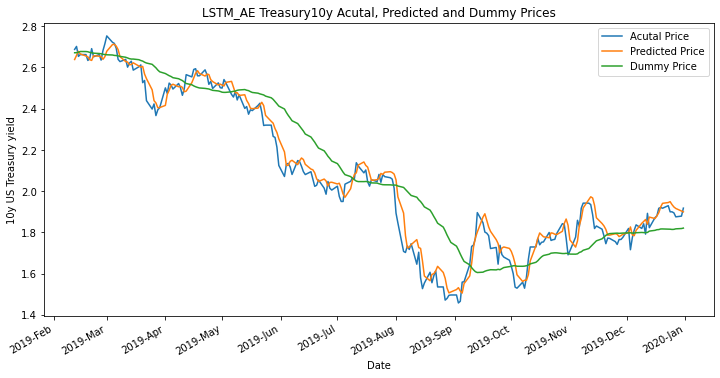

In [21]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

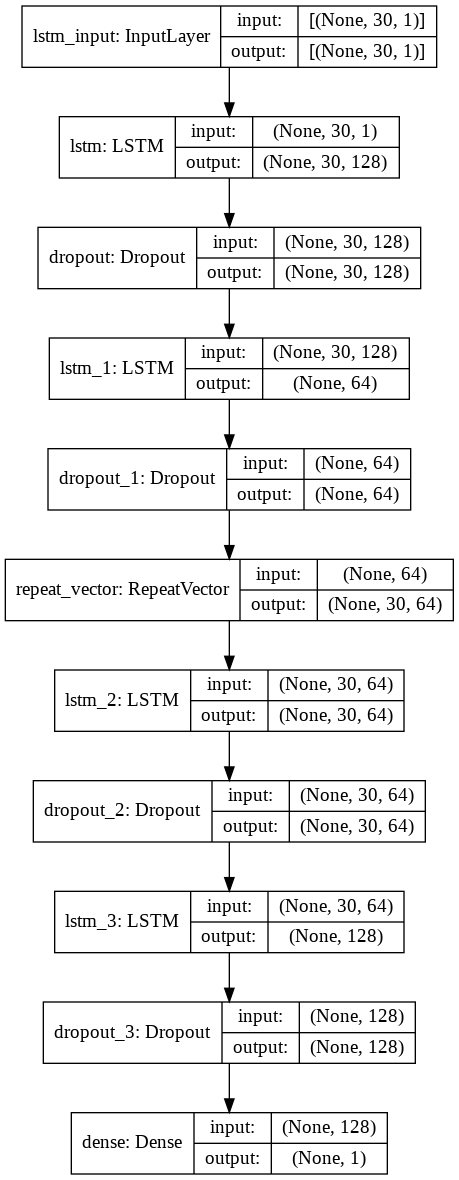

In [22]:
plot_model(model, show_shapes=True, expand_nested=True)

In [23]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.0015017012285088373
RMSE:  0.03875179000393191
MAE:  0.02990692246415782
Dummy MSE:  0.011907945328582062
Dummy RMSE:  0.10912353242349727
Dummy MAE:  0.08287353397503001


In [24]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/LSTM_AE_Treasury10y/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/LSTM_AE_Treasury10y/assets
